# CS-6580 Lecture 11 - Image Segmentation and Transpose Layers
**Dylan Zwick**

*Weber State University*

I was originally planning to cover transformers in class this week, but I've realized before we dive into transformers there are a few more things we need to learn about deep learning architectures. So, this week we'll be exploring those. Don't worry - transformers are coming. We just need to cover a bit more before then. We'll cover these additional architectures in the context of computer vision, so we'll be returning to that subject for a bit.

### Image Segmentation

This far we've primarily focused on one main computer vision task - image classification. We've seen many examples of this - classifying handwritten digits, classifying grayscale images of clothes, classifying dogs vs. cats, or even in your current homework assignment classifying alpacas vs. well, not alpacas. However, as you can probably guess, this isn't the only type of computer vision problem there is. Today, we'll focus on another one - *image segmentation*.

The idea behind image segmentation is that you want to segment (or partition) an image into different regions, where each region usually represents a category. One example of this that you may see quite  frequently is when you're on video calls, there may be a background image, and determining where the background image should be is a question of segmenting the image into the foreground (usually the person on the call) and the background, and then just replacing the background with the appropriate image.

But first, let's import some libraries we'll want to use:

In [11]:
#The standard data science trio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Our deep learning tools
import tensorflow as tf
from tensorflow import keras
from keras import layers

import random

#Some operating system functions that will help us get and manage our data
import os

#Some image tools that keras provides
from keras.utils import load_img, img_to_array, array_to_img

#Some image augmentation tools that keras provides
from keras.preprocessing.image import ImageDataGenerator

Now, a more precise formulation of the image segmentation task is to find a model that assigns a class to *each* pixel in an image, thus segmenting the image into different zones. Generally speaking, there are two different flavors of segmentation:

* **Semantic Segmentation** - Where each pixel is independently classified into a semantic category like "cat".
* **Instance Segmentation** - Where each pixel is not just placed within a semantic category, but into instances of that category. So, something like "cat 1", "cat 2", etc...

Segantic segmentation is, obviously, a bit easier, so that what we'll do in this first example.

We'll work with the Oxford-IIIT Pets dataset, which contains 7,399 pictures of various breeds of cats and dogs, together with foreground-background segmentation masks for each picture. A *segmentation mask* is the image-segmentation equivalent of a laber: it's an image the same size as the input image, with a single channel (sometimes called a "color channel") where each integer value corresponds to tho class of the corresponding pixel in the input image. In this specific case, the pixels can take one of three integer values:

* 1 - foreground
* 2 - background
* 3 - contour

We'll start by downloading the dataset.

In [2]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2024-02-20 14:24:23--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2024-02-20 14:24:23--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2024-02-20 14:24:24--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Perman

The pictures are stored as JPG files in the images/ folder, and the corresponding segmentation mask is stored as a PNG file with the same name in the annotations/trimaps/ folder. We can prepare the list of input file paths, and the list of the corresponding mask file paths:

In [3]:
input_dir = "images/"
target_dir = "annotations/trimaps/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

Let's take a quick look at these images. Here's a sample image:

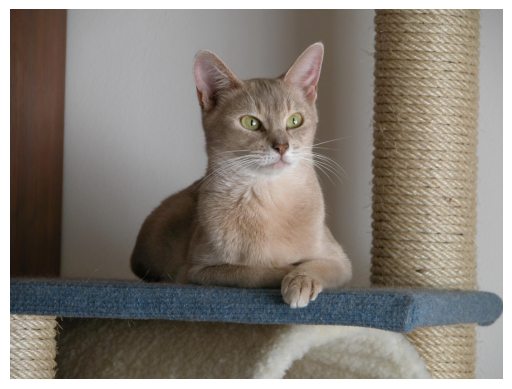

In [4]:
plt.axis("off")
plt.imshow(load_img(input_img_paths[42])); #We display the 42nd image, because why not?

And here is the corresponding target (segmentation mask):

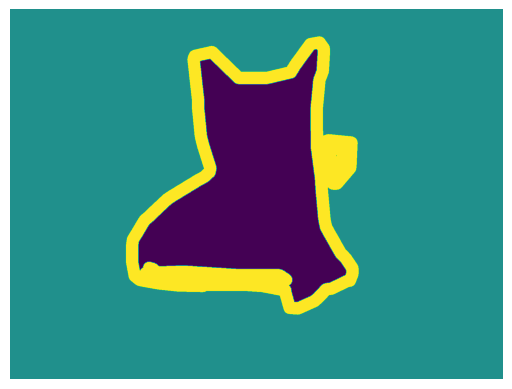

In [5]:
def display_target(target_array):
    #The original labels are 1, 2, and 3. We subtract 1, and then
    #multiply by 127 so the colors are black, gray, and near-white.
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[42], color_mode="grayscale"))
display_target(img)

Alright, looks good. Let's now load our inputs and targets into two NumPy arrays, and split the arrays into a training and validation set. There's not a ton of data here, so we can just load everything into memory.

In [6]:
img_size = (200, 200) #We resize everything to 200 x 200
num_imgs = len(input_img_paths) #Total number of samples in the data

random.Random(6580).shuffle(input_img_paths) #We shuffle the file paths as they were originally sorted by breed.
random.Random(6580).shuffle(target_paths) #We need to use the same seed, so the inputs line up with the targets.

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1 #We want our labels to be 0, 1, 2
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

num_val_samples = 1000 #Reserve 1000 samples for validation
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

Now let's build the model:

In [7]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

Alright, so let's take a look at what this model is  doing.

The first half closely resembles the kind of convolutional neural network (convnet) we've used for image classification - a stack of Conv2D layers with gradually increasing filter sizes, and decreasing spatial sizes. Specifically, we downsize our image three times by a factor of two each time, ending up with a layer of size (25,25,250). The idea is to encode images into smaller feature maps, where each spatial location contains information about a large spatial chuck of the original image.

Note something we did *not* do here is use MaxPooling2D layers. Instead, we used *strides*. We do this because MaxPooling layers destroy location information within each pooling window, which we really don't want to do here.

OK, but what's going on with that second part of the model. We use a bunch of these Conv2DTranspose calls. What are those? Well, the output of the first half of the model is a feature map of shape (25, 25, 256), and we need to apply a kind of *inverse* of the transformation we upsample the feature maps instead of downsampling them. You can view these as convolution layers that learn to upsample.

We now compile and fit our model: (You don't want to run this on a CPU)

In [8]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
                                    save_best_only=True)
]

history = model.fit(train_input_imgs, train_targets,
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/50
100/100 [==============================] - 112s 860ms/step - loss: 0.9514 - val_loss: 0.8978
Epoch 2/50
100/100 [==============================] - 61s 611ms/step - loss: 0.8950 - val_loss: 0.8858
Epoch 3/50
100/100 [==============================] - 63s 628ms/step - loss: 0.8298 - val_loss: 0.8289
Epoch 4/50
100/100 [==============================] - 63s 631ms/step - loss: 0.7967 - val_loss: 0.7715
Epoch 5/50
100/100 [==============================] - 63s 626ms/step - loss: 0.7667 - val_loss: 0.7656
Epoch 6/50
100/100 [==============================] - 63s 628ms/step - loss: 0.7714 - val_loss: 0.7652
Epoch 7/50
100/100 [==============================] - 61s 611ms/step - loss: 0.7515 - val_loss: 0.7197
Epoch 8/50
100/100 [==============================] - 62s 616ms/step - loss: 0.7437 - val_loss: 0.7009
Epoch 9/50
100/100 [==============================] - 63s 631ms/step - loss: 0.7212 - val_loss: 0.7291
Epoch 10/50
100/100 [==============================] - 63s 632ms/step - 

If we look at our validation and training loss, we see we start to overfit at around epoch 35:

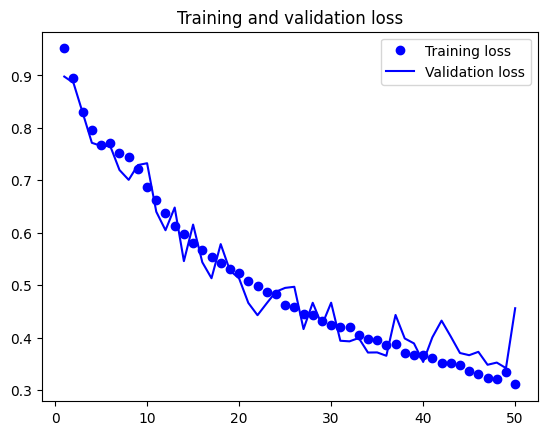

In [9]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

Fortunately for us, we were smart and saved our best performing model (on the validation loss). Let's use that to predict a segmentation mask:

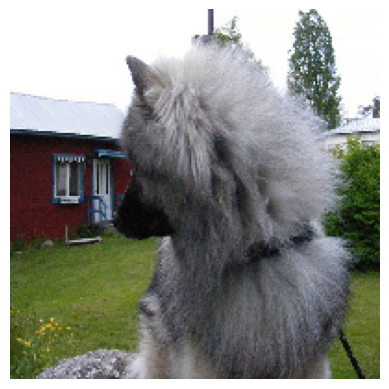

In [21]:
i = 22
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image));

1/1 [==============================] - 0s 283ms/step


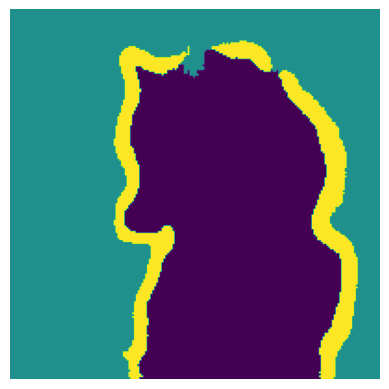

In [22]:
model = keras.models.load_model("oxford_segmentation.keras")

mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)

OK. So, what have we learned today:

* We've learned the basics behind a different kind of computer vision task.
* We've learned about a new type of neural network layer - the transpose layer.

Next time, we'll learn about a few more layers, and see how they can be valuably applied to some of the problems we've looked at so far.